In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import torch
import numpy
import pandas
import matplotlib

print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Version (if available): {torch.version.cuda}")
print(f"Numpy Version: {numpy.__version__}")
print(f"Pandas Version: {pandas.__version__}")
print(f"Matplotlib Version: {matplotlib.__version__}")

Python Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch Version: 2.8.0+cu126
CUDA Version (if available): 12.6
Numpy Version: 2.0.2
Pandas Version: 2.2.2
Matplotlib Version: 3.10.0


In [3]:
!git clone https://github.com/AlanDongMu/TimeGAN_PytorchRebuild.git /content/drive/MyDrive/BDA_TimeGAN_Project

Cloning into '/content/drive/MyDrive/BDA_TimeGAN_Project'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 56 (delta 14), reused 44 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 11.06 MiB | 13.86 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [4]:
%cd /content/drive/MyDrive/BDA_TimeGAN_Project
!ls

/content/drive/MyDrive/BDA_TimeGAN_Project
data		 main.py  networks.py  README.md  timegan.py	    utils.py
data_loading.py  metrics  output       run.py	  trained_networks


In [5]:
!ls /content/drive/MyDrive | grep household

household_power_consumption.txt


In [ ]:
!ls -lh /content/drive/MyDrive

total 11M
drwx------ 2 root root 4.0K Nov 13 13:48 'Colab Notebooks'
-rw------- 1 root root  10M Nov 13 14:02  household_power_consumption.txt
drwx------ 7 root root 4.0K Nov 13 13:56  TimeGAN_Project


In [6]:
import pandas as pd

df_full = pd.read_csv(
    "/content/drive/MyDrive/household_power_consumption.txt",
    sep=";",
    low_memory=False,
    na_values="?",
    nrows=1000000
)

print("Full dataset shape:", df_full.shape)
df_full.head()

Full dataset shape: (1000000, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [7]:
# 1) Combine Date and Time into a single datetime column
df_full['datetime'] = pd.to_datetime(
    df_full['Date'] + ' ' + df_full['Time'],
    format='%d/%m/%Y %H:%M:%S',
    errors='coerce'   # turn any bad formats into NaT
)

# 2) Drop rows where datetime couldn't be parsed (if any)
df_full = df_full.dropna(subset=['datetime'])

# 3) Drop the old Date & Time columns
df_full = df_full.drop(columns=['Date', 'Time'])

# 4) Set datetime as index
df_full = df_full.set_index('datetime')

print("After datetime processing:", df_full.shape)
df_full.head()

After datetime processing: (1000000, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [8]:
# Convert all columns to numeric (coerce errors → NaN)
df_full = df_full.apply(pd.to_numeric, errors='coerce')

# Count missing values
print("Missing values per column:")
print(df_full.isna().sum())

# Drop rows with any NaN values
df_full = df_full.dropna()

print("\nShape after dropna:", df_full.shape)
df_full.head()

Missing values per column:
Global_active_power      3990
Global_reactive_power    3990
Voltage                  3990
Global_intensity         3990
Sub_metering_1           3990
Sub_metering_2           3990
Sub_metering_3           3990
dtype: int64

Shape after dropna: (996010, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [9]:
from sklearn.preprocessing import MinMaxScaler

# Initialize global scaler (VERY IMPORTANT)
scaler = MinMaxScaler()

# Fit + transform full dataset
scaled_full = scaler.fit_transform(df_full)

print("Scaled shape:", scaled_full.shape)
print("Min values:", scaled_full.min(axis=0))
print("Max values:", scaled_full.max(axis=0))

Scaled shape: (996010, 7)
Min values: [0. 0. 0. 0. 0. 0. 0.]
Max values: [1. 1. 1. 1. 1. 1. 1.]


In [10]:
import numpy as np

seq_len = 60
data = scaled_full

sequences = []
for i in range(len(data) - seq_len):
    sequences.append(data[i:i+seq_len])

sequences = np.array(sequences)

print("Sequences shape:", sequences.shape)
print("One sequence sample:\n", sequences[0][:5])  # first 5 timesteps of first sequence

Sequences shape: (995950, 60, 7)
One sequence sample:
 [[0.39078724 0.30071942 0.39616056 0.39393939 0.         0.01282051
  0.5483871 ]
 [0.49877289 0.31366906 0.3539267  0.49350649 0.         0.01282051
  0.51612903]
 [0.50009439 0.35827338 0.34205934 0.49350649 0.         0.02564103
  0.5483871 ]
 [0.5014159  0.36115108 0.35776614 0.49350649 0.         0.01282051
  0.5483871 ]
 [0.33887106 0.37985612 0.42547993 0.33766234 0.         0.01282051
  0.5483871 ]]


In [11]:
# 80/20 split
train_size = int(len(sequences) * 0.8)

train_data = sequences[:train_size]
test_data  = sequences[train_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)

Train shape: (796760, 60, 7)
Test shape: (199190, 60, 7)


In [12]:
from types import SimpleNamespace

opt = SimpleNamespace(
    module="gru",           # RNN type
    hidden_dim=24,          # RNN hidden size (recommended)
    num_layer=3,            # number of layers
    batch_size=128,         # good for T4 GPU
    lr=0.001,               # learning rate
    gamma=1,                # GAN loss weight
    load_checkpoint=False,  # start fresh training
    networks_dir="trained_networks",

    # Training configuration
    iterations=500,         # 500 is enough for your dataset size
    print_times=10,         # print progress 10 times per phase

    # Sequence information
    seq_len=60,

    # Metrics & Output
    metric_iteration=2,
    output_dir="output",
    synth_size=0,                 # 0 = generate same size as real data
    only_visualize_metric=False
)

print("OPT SETUP COMPLETE")
print(opt)

OPT SETUP COMPLETE
namespace(module='gru', hidden_dim=24, num_layer=3, batch_size=128, lr=0.001, gamma=1, load_checkpoint=False, networks_dir='trained_networks', iterations=500, print_times=10, seq_len=60, metric_iteration=2, output_dir='output', synth_size=0, only_visualize_metric=False)


In [ ]:
import os

os.makedirs("trained_networks", exist_ok=True)
os.makedirs("output", exist_ok=True)

In [13]:
from run import train

print("🚀 Starting FULL TimeGAN training on entire dataset...")

train(opt, train_data)

print("🎉 FULL TRAINING COMPLETED — MODEL SAVED!")

🚀 Starting FULL TimeGAN training on entire dataset...
Start Embedding Network Training
step: 0/500, e_loss: 0.4455
step: 50/500, e_loss: 0.3829
step: 100/500, e_loss: 0.283
step: 150/500, e_loss: 0.2085
step: 200/500, e_loss: 0.1738
step: 250/500, e_loss: 0.1547
step: 300/500, e_loss: 0.1543
step: 350/500, e_loss: 0.1484
step: 400/500, e_loss: 0.1405
step: 450/500, e_loss: 0.1383
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/500, e_loss: 0.3762
step: 50/500, e_loss: 0.1387
step: 100/500, e_loss: 0.0515
step: 150/500, e_loss: 0.0302
step: 200/500, e_loss: 0.0208
step: 250/500, e_loss: 0.0155
step: 300/500, e_loss: 0.0123
step: 350/500, e_loss: 0.0102
step: 400/500, e_loss: 0.0088
step: 450/500, e_loss: 0.0078
Start Joint Training
step: 0/500, d_loss: 2.1203, g_loss_u: 0.6689, g_loss_s: 0.0076, g_loss_v: 0.3608, e_loss_t0: 0.1436
step: 50/500, d_loss: 1.8608, g_loss_u: 0.987, g_loss_s: 0.0006, g_loss_v: 0.3476, e_loss_t0: 0.1412
step: 100/500, d_loss:

In [15]:
import numpy as np

test_sample = test_data[np.random.choice(len(test_data), 2000, replace=False)]
print(test_sample.shape) #gpu isnot supporting 200k sequences

(2000, 60, 7)


🚀 Starting synthetic data generation + metrics...
Start Testing
Loading trained networks
Done.
Finish Synthetic Data Generation
Start discriminative_score_metrics
discriminative_score iteration:  0
discriminative_score:  0.35750000000000004
discriminative_score iteration:  1
discriminative_score:  0.48875
Finish discriminative_score_metrics compute
Start predictive_score_metrics
predictive_score iteration:  0
predictive_score:  0.22800117171020487
predictive_score iteration:  1
predictive_score:  0.23306225641463288
Finish predictive_score_metrics compute


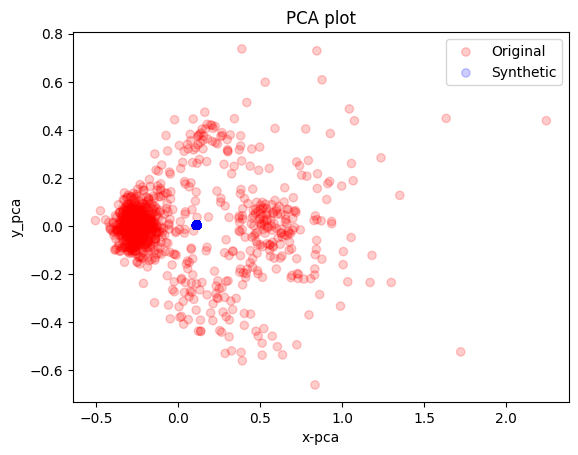

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.157s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.884422
[t-SNE] KL divergence after 300 iterations: 0.862170


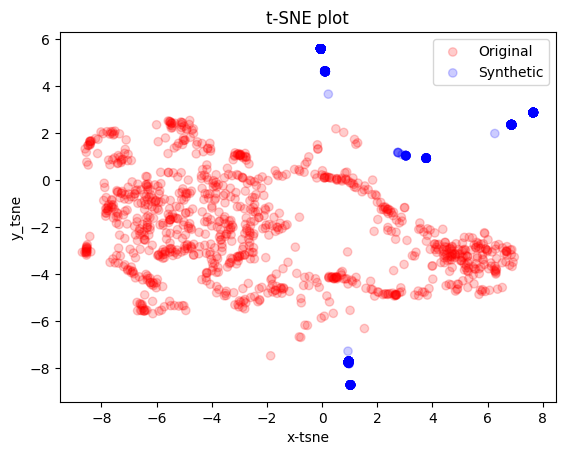

{'discriminative': np.float64(0.42312500000000003), 'predictive': np.float64(0.23053171406241887)}
🎉 Synthetic data + metrics completed!


In [16]:
from run import test

print("🚀 Starting synthetic data generation + metrics...")
test(opt, test_sample)
print("🎉 Synthetic data + metrics completed!")

In [17]:
import numpy as np
import pandas as pd
from run import test

# generate synthetic
model = timegan.TimeGAN(opt, train_data)
model.load_trained_networks()

gen = model.gen_synth_data(2000).cpu().detach().numpy()
flat = gen.reshape(2000, -1)

df_synth = pd.DataFrame(flat)
df_synth.to_csv("/content/drive/MyDrive/BDA_TimeGAN_Project/synthetic_data.csv", index=False)

print("Synthetic data saved!")

NameError: name 'timegan' is not defined

In [18]:
!zip -r /content/FINAL_TimeGAN_Project.zip /content/drive/MyDrive/BDA_TimeGAN_Project


  adding: content/drive/MyDrive/BDA_TimeGAN_Project/ (stored 0%)
  adding: content/drive/MyDrive/BDA_TimeGAN_Project/.git/ (stored 0%)
  adding: content/drive/MyDrive/BDA_TimeGAN_Project/.git/hooks/ (stored 0%)
  adding: content/drive/MyDrive/BDA_TimeGAN_Project/.git/hooks/applypatch-msg.sample (deflated 42%)
  adding: content/drive/MyDrive/BDA_TimeGAN_Project/.git/hooks/pre-rebase.sample (deflated 59%)
  adding: content/drive/MyDrive/BDA_TimeGAN_Project/.git/hooks/pre-commit.sample (deflated 45%)
  adding: content/drive/MyDrive/BDA_TimeGAN_Project/.git/hooks/pre-push.sample (deflated 49%)
  adding: content/drive/MyDrive/BDA_TimeGAN_Project/.git/hooks/pre-applypatch.sample (deflated 38%)
  adding: content/drive/MyDrive/BDA_TimeGAN_Project/.git/hooks/pre-receive.sample (deflated 40%)
  adding: content/drive/MyDrive/BDA_TimeGAN_Project/.git/hooks/commit-msg.sample (deflated 44%)
  adding: content/drive/MyDrive/BDA_TimeGAN_Project/.git/hooks/prepare-commit-msg.sample (deflated 50%)
  addi